In [1]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
# from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [2]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

BINS = [-1.0, -0.7962963 , -0.55, -0.31859399, -0.28888889, -0.27279798, -0.2503496 ,
       -0.22473535, -0.2       , -0.16676868, -0.11454837, -0.0353191 ,
        0.01857333,  0.07800226,  0.12310686,  0.15539933,  0.17979046,
        0.19944761,  0.21551724,  0.23020181,  0.26149425,  0.52298851, 0.76, 1.0]

def newunbin_Y(angle_out):
    def newunbin_angle(angled_binned):
        i = np.argmax(angled_binned)
        return (BINS[i] + BINS[i+1])/2.0
    
    return np.array([newunbin_angle(o) for o in angle_out])

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
#     predicted = newunbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

def linear_unbin(arr):
    b = np.argmax(arr)
    a = b *(2/14) - 1
    return a


def bin_Y(Y):
    d = []
    for y in Y:
        arr = np.zeros(15)
        arr[linear_bin(y)] = 1
        d.append(arr)
    return np.array(d)

def unbin_Y(Y):
    d=[]
    for y in Y:
        v = linear_unbin(y)
        d.append(v)
    return np.array(d)

Tub does exist


0.056037294533554556

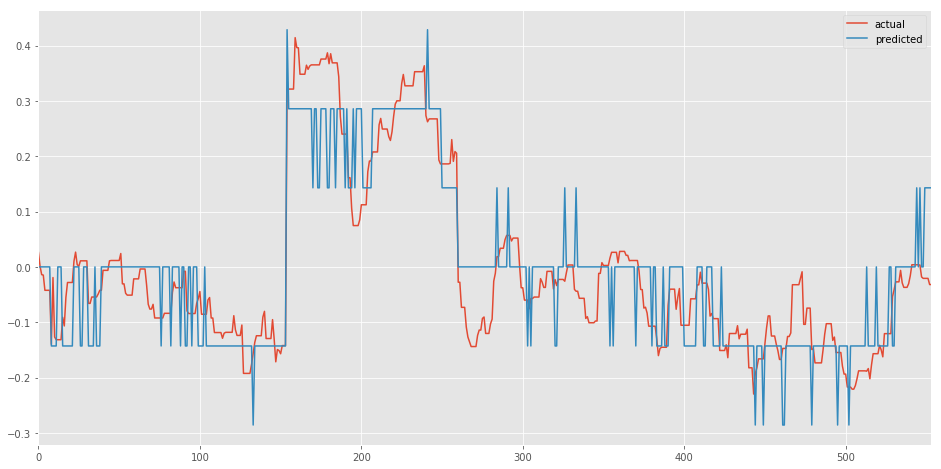

In [9]:
model = keras.models.load_model('../../donkeycar/d2/models/oak.cls.0.61')
dataset = dataset_from_tub("../../donkeycar/d2/data.oakland.golden/tub_1_17-09-16", limit=-1)
predicted, actual = output_pair_cat(model, dataset)
df = pd.DataFrame(dict(predicted=predicted, actual=actual))
# df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted']).mean()

Tub does exist


0.045724002405848584

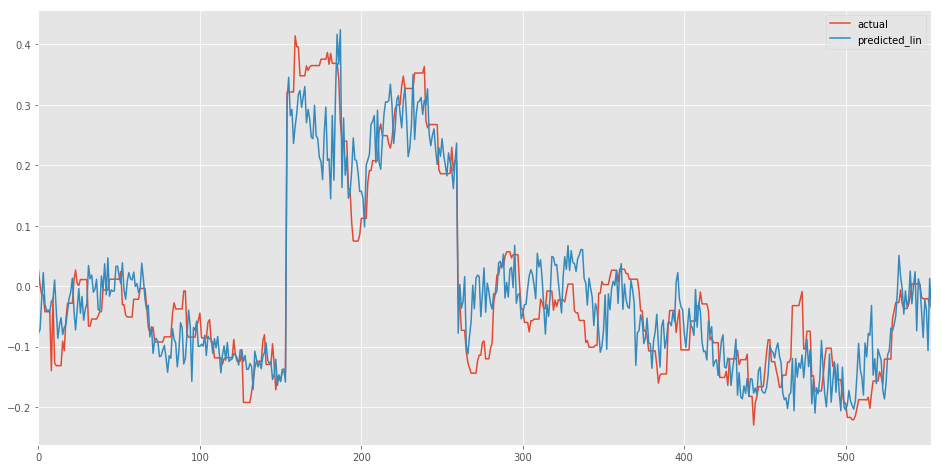

In [7]:
# dataset = dataset_from_all_tubs("../../donkeycar/d2/data")
dataset = dataset_from_tub("../../donkeycar/d2/data.oakland.golden/tub_1_17-09-16", limit=-1)
model = keras.models.load_model('../../donkeycar/d2/models/oak.4fc_l1.0.05')

predicted_lin, actual = output_pair_lin(model, dataset)
df = pd.DataFrame(dict(predicted_lin=predicted_lin[:,0], actual=actual))
# df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted_lin']).mean()